# Introduction
Welcome to todays lab session where we will focus on regularisation and model selection applied to a linear regression problem. This lab will all be in Python, but the majority of the code is provided for you. Please try and trace through the code, and understand what each line does. Run the code, and experiment with what happens when you change things to improve your understanding.

The easiest way to complete this session is to log into a Google account and save a copy to your google drive. Alternatively, you could save this document to your machine and open as a Jupyter notebook.

In [ ]:
# Import numpy for linear algebra support
import numpy as np
# Matplotlib is our main data plotting library
import matplotlib.pyplot as plt

# Set a training data range that's smaller than our test range, so we can demonstrate extrapolation
x_train_range = [-25, 25]
x_test_range = [-40, 40]



# Creating some data
As we did in the regression lab, we'll generate some data to play with. To make the problem more interesting, we're going to generate data that follows a slightly more complex function than the models we're using to fit it.

Below is a function called create_data, which randomly generates some quadratic model weights, with a weighted sin component to synthesise some data. Note that the function takes a parameter called noise_sigma. This refers to the Gaussian/Normally distributed random noise that we expect to see in our model. It also takes n_samples, the number of data samples to generate.

In this case we're generating separate training, validation and test datasets. The test data has a slightly bigger range to test extrapolation. Remember not to look at the test data until the end!

1. Try running the code below a few times, and note how the resulting plot changes each time you run it. Why is the plot changing? What do you notice about the plot for different model weight values?

2. Try adjusting the value of sigma, what effect does this have on the plots?

The true function weights:  [0.6445500186252922, 0.07113875829965072, 0.11172670628144198, -3.3199483998216754, 1.3484144976480836]


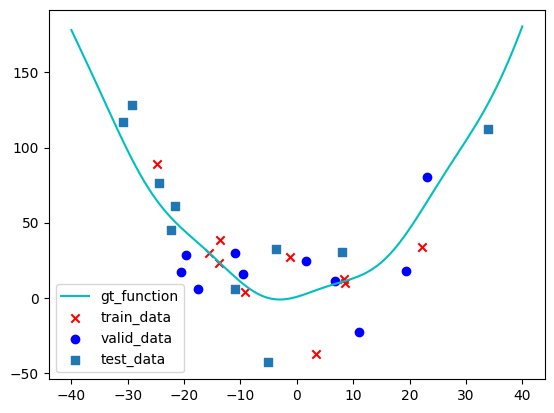

In [ ]:
# Let's start by defining a function some data that follows a linear assumption
# Note, if you change random seed to a number it will return consisten results
def create_data(noise_sigma=20.0, n_samples=10, random_seed=None):
  # Create a random number generator with the specified seed
  rng = np.random.default_rng(random_seed)

  def create_x_samples(min_max_vals, n_samples):
    x_samples = rng.uniform(size=n_samples) * (min_max_vals[1] - min_max_vals[0]) + min_max_vals[0]
    x_samples = np.reshape(x_samples, (-1, 1))
    return x_samples

  # Sample some random points in x for training/validation/testing data
  x_train = create_x_samples(x_train_range, n_samples)
  x_valid = create_x_samples(x_train_range, n_samples)
  x_test = create_x_samples(x_test_range, n_samples)


  # Let's randomly generate some coefficient weights
  weights = [rng.standard_normal(), rng.standard_normal(), rng.standard_normal()*0.1, rng.standard_normal()*10, rng.standard_normal()*0.5]

  def calculate_y_values(_x, _weights, _sigma):
    # Regression defines a generative model of our observed target variables
    # So we can use the same model to generate our training data.
    y = _weights[0] + _x*_weights[1] + np.square(_x)*_weights[2] + np.sin(_x/weights[3])*weights[3]
    # We need to remember to add our residual model noise. We sample random normally
    # distributed values and scale them by the standard deviation
    y += rng.standard_normal(size=y.shape) * _sigma
    return y

  # Generate some training, validation and test data using the same model weights, but
  # at different x values and with different noise levels
  train_data = (x_train, calculate_y_values(x_train, weights, noise_sigma))
  valid_data = (x_valid, calculate_y_values(x_valid, weights, noise_sigma))
  test_data = (x_test, calculate_y_values(x_test, weights, noise_sigma))

  # Let's store the noise free, ground truth function in the right range for plotting
  # In the real world we would never have this!
  x_gt = np.reshape(np.linspace(*x_test_range, 100), (-1, 1))
  gt_data = (x_gt, calculate_y_values(x_gt, weights, 0.0))

  return train_data, valid_data, test_data, gt_data, weights

# If we call this function it returns some x and y points as well as the real model weights
train_data, valid_data, test_data, gt_data, weights = create_data(noise_sigma=20)

print('The true function weights: ', weights)
# Show the ground truth function in cyan
plt.plot(*gt_data, 'c-', label='gt_function')
# Show the training data as x
plt.scatter(*train_data, marker='x',c='r', label = 'train_data')
# Show the validation data as o
plt.scatter(*valid_data, marker='o',c='b', label = 'valid_data')
# Show the test data as o
plt.scatter(*test_data, marker='s', label = 'test_data')

plt.legend()
plt.show()

# Fitting a model to data
Here we'll fit a regularised least squares line regression model to the data.

1. Read through the code below and see how this equates with the mathematics in the slides. Particularly look at fit_linear_regression, which implements the regularised least squares regression $$(X^TX + N\lambda I)^{-1} X ^T\mathbf{y}$$
Also look at augment_x and see how it allows us to fit a polynomial function to the data.

2. Run the code for different generated data samples (running create_data again). Experiments with the poly_order and _reg_weight parameters to fit_linear_gression.

3. Try adjusting the number of data samples and noise values in created data. How does this affect the results?

4. Fill in the function calc_error such that it gives the mean squared error. Does it give different results for the training data and the validation data. Why?


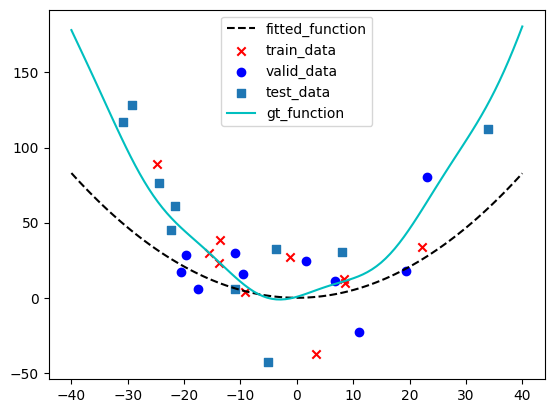

Training Error:  692.6823082733507
Validation Error:  515.4499034414268


In [ ]:
def augment_x(data, poly_order):
  # Augment the x_data to allow for a polynomial model of the data
  return np.concatenate([np.power(data, p) for p in range(poly_order+1)], axis=1)

def fit_linear_regression(_x, _y, _reg_weight=0.0, poly_order=2):
  # This time we're allowing for L2 regularisation on the model weights. To
  # increase the strength of the regularisation adjust the value _reg_weight
  # You can also change the order of the polynomial with poly_order
  n_data_samples = len(_x)
  _x = augment_x(_x, poly_order)
  estimated_weights = np.dot(np.linalg.inv(np.dot(_x.T,_x)+n_data_samples*_reg_weight*np.eye(_x.shape[1])), np.dot(_x.T, _y))
  return estimated_weights

def f_hat(_x, _w):
  # Calculate our predicted points for each value of x
  y_hat = np.matmul(augment_x(_x, len(_w)-1), _w)
  return y_hat

estimated_weights = fit_linear_regression(*train_data, 100000)

# Calculate our predicted points for each value of x
y_hat = f_hat(gt_data[0], estimated_weights)

def plot_function(model_weights):
  # Plot the fitted function outside of the range with a black dotted line
  plt.plot(gt_data[0], f_hat(gt_data[0], model_weights), 'k--', label='fitted_function')
  # Show the training points as red crosses
  plt.scatter(*train_data, marker='x',c='r', label = 'train_data')
  plt.scatter(*valid_data, marker='o',c='b', label = 'valid_data')
  plt.scatter(*test_data, marker='s', label = 'test_data')
  # Show the ground truth function in cyan
  plt.plot(*gt_data, 'c-', label='gt_function')
  plt.legend()
  plt.show()

plot_function(estimated_weights)

# Fill in the calculation of the mean squared error
def calc_error(data_tuple, _w):
  pred = f_hat(data_tuple[0], _w)
  mean_squared_error = np.mean(np.square(data_tuple[1] - pred))
  return mean_squared_error
print("Training Error: ", calc_error(train_data, estimated_weights))
print("Validation Error: ", calc_error(valid_data, estimated_weights))


# Systematic experimentation with regularisation.
Let's try and be a bit more rigorous and draw a plot of how the error on our validation set changes as we alter the regularisation parameter.
1. Fill in the blanks within the for loop to create a plot of the training/validation error as you vary the regularisation. What do you notice about how the error changes on training/validation data.
2. Experiment with the change the polynomial order of the regression model. What do you notice?

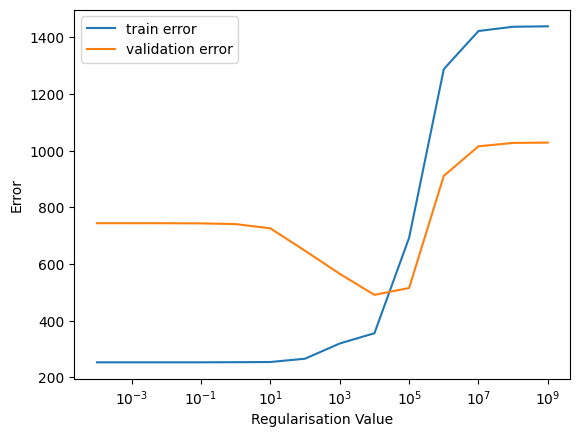

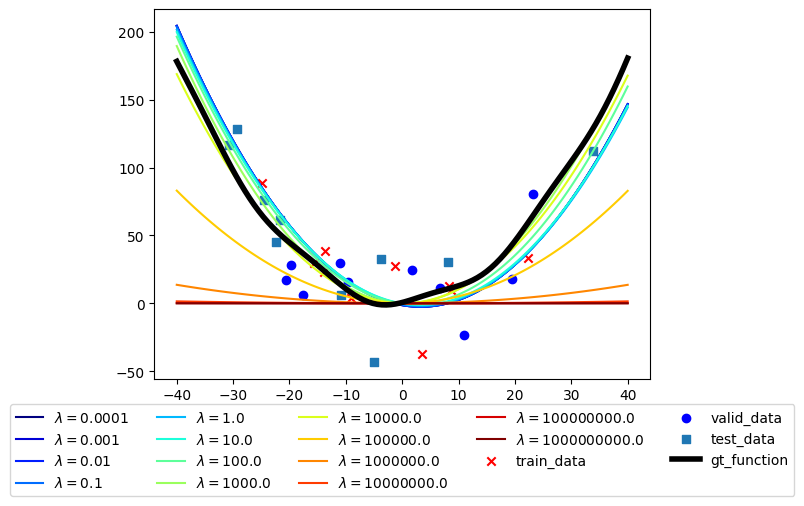

In [ ]:
# Create a wide range of regularisation values from 10^-4 to 10^10
reg_vals = np.power(10, np.arange(-4,10, dtype=np.float64))

train_error = np.zeros_like(reg_vals)
valid_error = np.zeros_like(reg_vals)
all_estimated_weights = []
for idx, reg_val in enumerate(reg_vals):
  # You may use the same function as before for calculating weights
  # but now you need to set the regularisation hyperparameter reg_val
  estimated_weights = fit_linear_regression(*train_data, reg_val, 2)
  all_estimated_weights.append(estimated_weights)
  train_error[idx] =  calc_error(train_data, estimated_weights)
  valid_error[idx] =  calc_error(valid_data, estimated_weights)
# Draw plots with the x axis (regularisation) on a log scale.
plt.semilogx(reg_vals, train_error, label='train error')
plt.semilogx(reg_vals, valid_error, label='validation error')
plt.xlabel("Regularisation Value")
plt.ylabel("Error")
plt.legend()
plt.show()

def plot_function_regularisation(_weights, reg_vals):
  colors = plt.cm.jet(np.linspace(0,1,len(reg_vals)))
  for idx, reg_val in enumerate(reg_vals):
    # Plot the fitted function outside of the range with a black dotted line
    plt.plot(gt_data[0], f_hat(gt_data[0], _weights[idx]),
             color=colors[idx], label=r'$\lambda=$' + str(reg_val))
  # Show the training points as red crosses
  plt.scatter(*train_data, marker='x',c='r', label = 'train_data')
  plt.scatter(*valid_data, marker='o',c='b', label = 'valid_data')
  plt.scatter(*test_data, marker='s', label = 'test_data')
  # Show the ground truth function here in black
  plt.plot(*gt_data, 'k-', label='gt_function', linewidth=4)
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
  plt.show()

# Plot the different instances of our model
plot_function_regularisation(all_estimated_weights, reg_vals)


# Now let's try looking at model complexity and regularisation
Ideally, we would optimise over both model complexity and regularisation to do our model selection. Which is what we do here!
1. Run the code below and look at the plots. Can you explain what the plots mean and why they look as they do?
2. Look at the code for choosing the best model parameters and try and follow what it's doing. What happens if you pass the train-error to choose_best_model? Does it give different results?
2. Calculate the model using the best parameters of the validation set. Plot the performance of the best model against the ground truth function, hint we saw some code for doing this earlier in the lab.
3. Calculate the error on the test data and compare against the validation data. Are they different? Why might that be the case?
4. Try running all the code again with different sets of random data

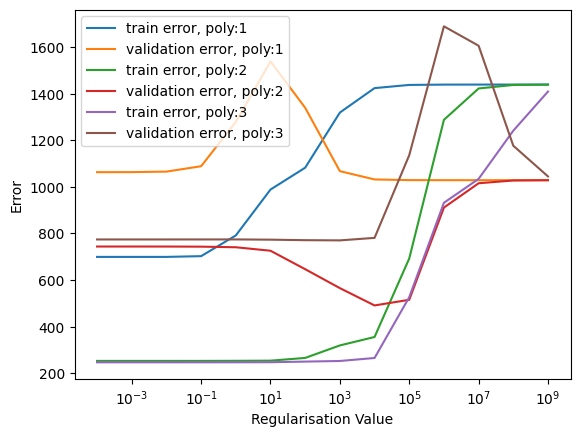

best on validation data poly:  2  best reg:  10000.0
best on training data poly:  3  best reg:  0.0001


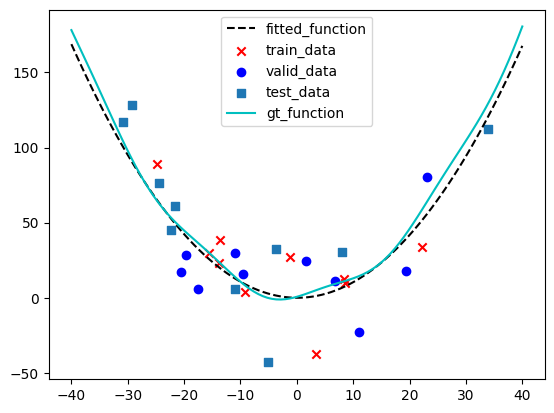

Validation error:  491.22045166789223
Test error:  580.9773530876988


In [ ]:
reg_vals = np.power(10, np.arange(-4,10, dtype=np.float64))
# Choose a range of polynomial orders to test
poly_vals = np.arange(1,4)
# Create arrays to store the error on the training/validation sets
train_error = np.zeros((len(poly_vals), len(reg_vals)))
valid_error = np.zeros((len(poly_vals), len(reg_vals)))

# Go through the different model set ups and store the error
for poly_idx, poly_order in enumerate(poly_vals):
  for reg_idx, reg_val in enumerate(reg_vals):
    estimated_weights = fit_linear_regression(*train_data, reg_val, poly_order)
    train_error[poly_idx, reg_idx] =  calc_error(train_data, estimated_weights)
    valid_error[poly_idx, reg_idx] =  calc_error(valid_data, estimated_weights)

for poly_idx, poly_order in enumerate(poly_vals):
  # Draw plots with the x axis (regularisation) on a log scale.
  plt.semilogx(reg_vals, train_error[poly_idx], label='train error, poly:'+str(poly_order))
  plt.semilogx(reg_vals, valid_error[poly_idx], label='validation error, poly:' + str(poly_order))
plt.xlabel("Regularisation Value")
plt.ylabel("Error")
plt.legend()
plt.show()

def choose_best_model(error_array):
  # Choose the index with the best error
  best_idx = np.argmin(error_array)
  # Calculate the best polynomial index
  best_poly_idx = best_idx // len(reg_vals)
  # Calculate the best regularisation index
  best_reg_idx = best_idx - best_poly_idx*len(reg_vals)
  # Now get the actual values
  best_poly = poly_vals[best_poly_idx]
  best_reg = reg_vals[best_reg_idx]
  return best_poly, best_reg

best_poly, best_reg = choose_best_model(valid_error)
print("best on validation data poly: ", best_poly, " best reg: ", best_reg)

# Calculate and print the optimal model parameters according to the training error
best_train_poly, best_train_reg = choose_best_model(train_error)
print("best on training data poly: ", best_train_poly, " best reg: ", best_train_reg)

# Calculate the model using the best parameters of the validation set.
estimated_weights = fit_linear_regression(*train_data, best_reg, best_poly)

# Plot the performance of the best model against the ground truth function
plot_function(estimated_weights)

# Calculate the error on the test data and compare against the validation data.
print("Validation error: ", calc_error(valid_data, estimated_weights))
print("Test error: ", calc_error(test_data, estimated_weights))


# Extensions
These are all completely optional!

+ Try combining your training and validation data for creating the final model. How does this improve perfomance on your test data.

+ Make the data more complex! Make the level of noise vary with x (hetroscedastic noise), which breaks one of the assumptions of the model. How does that effect performance? Can you implement weighted least squares regression to counteract this?

+ Apply linear regression (or logistic regression for classification) to some of the datasets from [scikit-learn](https://scikit-learn.org/stable/datasets/toy_dataset.html).

+ The bias-variance decomposition lets us examine the effect on the learned models function when we refit the model using different samples of our dataset. Try generating several versions of the dataset with the same underlying generating function, but with different realisations of added noise. Fit a model using each of these versions of the dataset, and calculate the bias and variance of the model solutions. See this [tutorial](https://towardsdatascience.com/the-bias-variance-tradeoff-8818f41e39e9) for some ideas or check Chris Bishop's [book](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) on page 147.